In [1]:
import hopsworks
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from matplotlib import pyplot
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib
import os

/home/codespace/.python/current/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# You have to set the environment variable 'HOPSWORKS_API_KEY' for login to succeed
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Multiple projects found. 

	 (1) prometheus
	 (2) liuyunlu

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/194714
Connected. Call `.close()` to terminate connection gracefully.


In [3]:
# The feature view is the input set of features for your model. The features can come from different feature groups.    
# You can select features from different feature groups and join them together to create a feature view
wine_fg = fs.get_feature_group(name="wine", version=1)
query = wine_fg.select_all()
feature_view = fs.get_or_create_feature_view(name="wine",
                                  version=1,
                                  description="Read from Wine Quality dataset",
                                  labels=["quality"],
                                  query=query)

In [4]:
# You can read training data, randomly split into train/test sets of features (X) and labels (y)        
X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)

# Train our model with the Scikit-learn K-nearest-neighbors algorithm using our features (X_train) and labels (y_train)
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train.values.ravel())

Finished: Reading data from Hopsworks, using ArrowFlight (0.93s) 


KNeighborsClassifier()

In [5]:
X_train

,type,volatile_acidity,chlorides,density,alcohol
0,1,0.320,0.041,0.99235,11.0
1,1,0.200,0.030,0.99320,10.2
2,1,0.180,0.042,0.99400,9.4
4,1,0.445,0.040,0.99380,10.8
5,1,0.230,0.045,0.99220,11.3
...,...,...,...,...,...
5278,0,0.640,0.115,0.99840,10.1
5279,1,0.155,0.045,0.99340,9.9
5280,1,0.335,0.033,0.99002,12.3
5281,1,0.250,0.034,0.99085,11.9


In [6]:
y_train

,quality
0,1
1,1
2,0
4,0
5,1
...,...
5278,1
5279,1
5280,1
5281,1


In [7]:
# Evaluate model performance using the features from the test set (X_test)
y_pred = model.predict(X_test)

# Compare predictions (y_pred) with the labels in the test set (y_test)
metrics = classification_report(y_test, y_pred,output_dict=True)
results = confusion_matrix(y_test, y_pred)

In [8]:
metrics_print=classification_report(y_test, y_pred)
print(metrics_print)
print(results)

              precision    recall  f1-score   support

           0       0.63      0.56      0.59       407
           1       0.74      0.79      0.77       650

    accuracy                           0.70      1057
   macro avg       0.69      0.68      0.68      1057
weighted avg       0.70      0.70      0.70      1057

[[229 178]
 [135 515]]


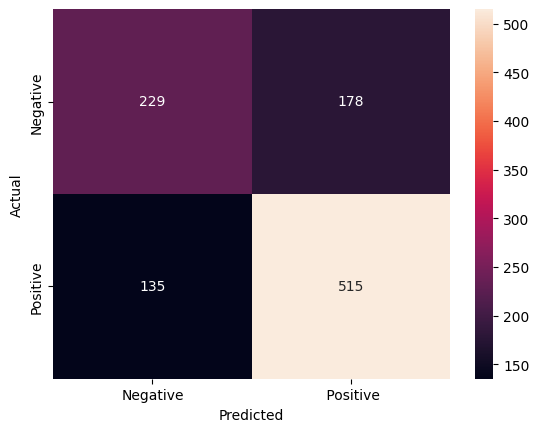

In [9]:
# Create the confusion matrix as a figure, we will later store it as a PNG image file
df_cm = pd.DataFrame(results,["Negative", "Positive"],["Negative"," Positive"])
cm = sns.heatmap(df_cm, annot=True, fmt='d')
cm.set_xlabel('Predicted')
cm.set_ylabel('Actual')

fig = cm.get_figure()

In [10]:
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

# The contents of the 'iris_model' directory will be saved to the model registry. Create the dir, first.
model_dir="wine_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(model, model_dir + "/wine_model.pkl")
fig.savefig(model_dir + "/confusion_matrix.png")    

# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
iris_model = mr.python.create_model(
    name="wine_model", 
    metrics={"accuracy" : metrics['accuracy']},
    model_schema=model_schema,
    description="Wine Quality Predictor"
)

# Upload the model to the model registry, including all files in 'model_dir'
iris_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


Uploading: 100.000%|██████████| 436198/436198 elapsed<00:02 remaining<00:00  3.97it/s]
Uploading: 100.000%|██████████| 19869/19869 elapsed<00:01 remaining<00:001,  3.97it/s]
Uploading: 100.000%|██████████| 537/537 elapsed<00:01 remaining<00:00<00:09,  2.28s/it]
Model export complete: 100%|██████████| 6/6 [00:11<00:00,  1.96s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/194714/models/wine_model/1


Model(name: 'wine_model', version: 1)